# CW2 - Coding Part 2 (30 points)
# Variational Autoencoders
Build a Convolutional Variational AutoEncoder and achieve best possible reconstruction and latent space disentanglement. Then answer the questions.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchsummary import summary

import matplotlib.pyplot as plt
import pandas as pd
import altair as alt

In [2]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

In [4]:
# Load the data

#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

#                 ** MODIFY CODE HERE IF NECESSARY **
# import torchvision.transforms as transforms
class Binarize(object):
    def __call__(self, image):
        threshold = 0.5
        return (image > threshold).float()

batch_size = 64

data_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        Binarize()
    ]
)

def denormalize(x):
    return x

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms,
)

train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
)

# Download test data
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms,
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
)

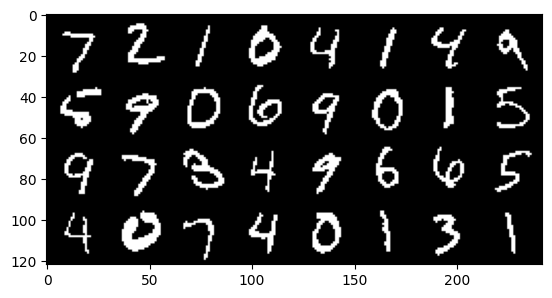

In [5]:
sample_inputs, _ = next(iter(test_dataloader))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denormalize(fixed_input), nrow=8, padding=2, normalize=False,
                scale_each=False, pad_value=0)
plt.figure()
show(img)

# Variational Auto Encoders (VAEs)

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">2</a>.
  </figcaption>
</figure>

## Build a convolutional VAE (5 points)

The only requirement is that it contains convolutions both in the encoder and decoder. You can still use some linear layers if needed.

Min value: 0.0
Max value: 1.0


(array([1361454.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,  206546.]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 <BarContainer object of 9 artists>)

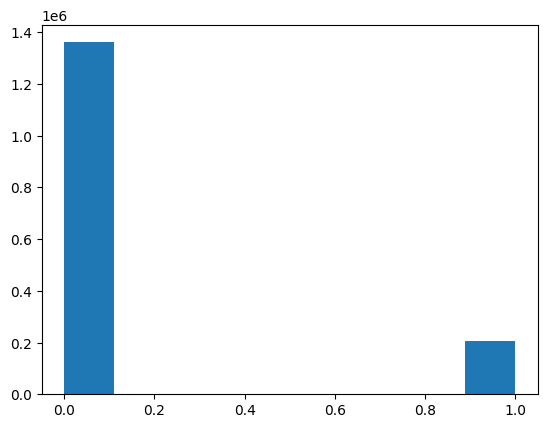

In [6]:
training_data[0][0].shape
28*28
all_data = torch.vstack([x for x, _ in training_data])
print('Min value:', all_data.min().item())
print('Max value:', all_data.max().item())

# Plot histogram for a random subset
subsample_size = 2000
indices = np.random.choice(all_data.shape[0], size=subsample_size, replace=False)
plt.hist(all_data[indices].flatten().numpy(), bins=np.linspace(0, 1, num=10))

In [30]:
import pdb
import torch.nn.functional as F
# Convolutional VAE implementation here

### VAE CODE IS RECYCLED FROM https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/1_VAE_mnist_sigmoid_mse.ipynb
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]
    
    
class VAE(nn.Module):
    def __init__(self, latent_dim = 2):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        self.latent_dim = latent_dim
        
        ### ENCODER
        self.enc_model = nn.Sequential(
                nn.Conv2d(1, 16, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(16, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        # Create separate final layers for each parameter (mean and log-variance)
        # I use log-variance to unconstrain the optimisation of the positive-only variance parameters
        self.enc_mean = nn.Linear(32 * 7 * 7, self.latent_dim)
        self.enc_logvar = nn.Linear(32 * 7 * 7, self.latent_dim)

        ### DECODER
        self.dec_model = nn.Sequential(
                torch.nn.Linear(self.latent_dim, 32 * 7 * 7),
                Reshape(-1, 32, 7, 7),
                nn.ConvTranspose2d(32, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 16, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(16, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )
        

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        '''
        x (B, C, H, W): Batch of input MNIST digits
        '''
        features = self.enc_model(x)
        mean = self.enc_mean(features)
        logvar = self.enc_logvar(features)

        return mean, logvar

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        '''
        mu, logvar are the outputs of the encoder
        '''
        std = torch.exp(0.5*logvar)
        eps = torch.randn(mu.size(0), mu.size(1)).to(mu.device)
        Z = mu + eps*std
        return Z.to(device=std.device)

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # pdb.set_trace()
        '''
        z is the latent from which to reconstruct the input
        '''
        features = self.dec_model(z)
        # pdb.set_trace()
        return features 

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        '''
        x (B, C, H, W): Batch of input MNIST digits
        '''
        mu, logvar = self.encode(x)        # (B, H) , (B, H)
        z = self.reparametrize(mu, logvar) # (M, B, H); z is of size (B, H=2)
        recon_x = self.decode(z)           # recon_x (B, C, H, W)
        # pdb.set_trace()
        
        ###

        return recon_x, mu, logvar 
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################


#######################################################################
#                       ** START OF YOUR CODE **
#######################################################################

latent_dim = 2 

#######################################################################
#                       ** END OF YOUR CODE **
#######################################################################
print(device)
model = VAE(latent_dim).to(device)
summary(model, (1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         LeakyReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         LeakyReLU-4           [-1, 32, 14, 14]               0
            Conv2d-5             [-1, 32, 7, 7]           9,248
         LeakyReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 32, 7, 7]           9,248
           Flatten-8                 [-1, 1568]               0
            Linear-9                    [-1, 2]           3,138
           Linear-10                    [-1, 2]           3,138
           Linear-11                 [-1, 1568]           4,704
          Reshape-12             [-1, 32, 7, 7]               0
  ConvTranspose2d-13             [-1, 32, 7, 7]           9,248
        LeakyReLU-14             [

In [31]:
### debugging
fst_batch = next(iter(train_dataloader))
fst_batch = fst_batch[0].to('cuda')
recon_x , mu, logvar= model(fst_batch)
torch.sum(recon_x < 0.5)

tensor(37941, device='cuda:0')

Briefly Explain your architectural choices

<font color='red'>***YOUR ANSWER***</font>

First, because there exists a plethora of tutorials of VAEs trained on the MNIST dataset, I simply recycled existing code on the internet. Namely, I used code from this [tutorial](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/1_VAE_mnist_sigmoid_mse.ipynb) and [here](https://github.com/vsimkus/pmr2023-vae). I can try explaining their architectural choices: for a convolution based VAE, there has to be convolutional layers, whereby layers in the decoder are essentially the transpose to those of the encoder. Dimensions such as number of channels are arbitrarily set. There are some slight fixes to be made such as Trim() to ensure that the output of the VAE is the same size as the input, in this case (1, 28, 28). Another important addition is the sigmoid activation function on the decoder's last layer. This is because I'm modelling binarized MNIST pixel values, where each pixel has been preprocessed to be either 0 or 1 as per a 0.5 threshold, as shown in the histogram above. 

## Defining a Loss (6 points)

The Beta VAE loss, with encoder $q$ and decoder $p$:
$$ L=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

The loss you implement depends on your choice of latent prior and model outputs.

There exist different solutions that are equally correct. Depending on your assumptions you might want to do a data preprocessing step.



In [20]:
def loss_function_VAE(recon_x, x, mu, logvar, beta):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
    '''
    B = 64, C = 1, H = W = 28
    recon_x: (B, C, H, W) output of my conv. VAE
    x: (B, C, H, W) ground truth binarized MNIST digit
    mu, logvar: parameters of my variational distribution p(z|x)
    beta: hyperparamter controlling the trade-off between the 
          reconstruction and the regularization loss.
    '''
    # KL divergence between learned latent distribution 
    # and the prior distribution p(z) 
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())           # scalar
    
    # reconstruction loss or negative cross entropy. use bce 
    # for binarized mnist digits
    neg_cross_entropy = F.binary_cross_entropy(recon_x, x, reduction='sum') # scalar; loss for each datapoint
    
    # Beta VAE loss or Langragian 
    langragian = neg_cross_entropy - beta * kld                             # scalar
    avg_langragian = langragian.mean()
    
    # pdb.set_trace()
    # use the opposite sign because standard optimizers minimize, but I want to maximize the Langragian 
    loss =  neg_cross_entropy + beta * kld 
    return avg_langragian, loss, neg_cross_entropy, kld

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

In [21]:
fst_batch.shape
elbo, loss, neg_cross_entropy, kld = loss_function_VAE(recon_x, fst_batch, mu, logvar, 0.5)
print(loss, elbo, neg_cross_entropy, kld)

tensor(35150.9609, device='cuda:0', grad_fn=<AddBackward0>) tensor(35150.7812, device='cuda:0', grad_fn=<MeanBackward0>) tensor(35150.8711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0.1835, device='cuda:0', grad_fn=<MulBackward0>)


Briefly answer the following:

a.   Explain what are the possible choices of reconstruction loss, and which one you choose. Explain how it relates to

1.   Your choice of VAE prior
2.   The output data domain
3.   The latent space disentanglement

Feel free to try and train with different reconstruction losses to see which one works best

<font color='red'>***YOUR ANSWER***</font>

a. There are different reconstruction losses depending on the assumptions made on the support of each pixel value of the MNIST image. I **binarized** the MNIST digits, and thus each pixel value is {0, 1}, i.e. a Bernoulli variable. Thus, for reconstruction loss it'd be most appropriate to model each pixel using the Bernoulli distribution, which is equivalent to using the binary cross entropy as the reconstruction loss. If I didn't binarize them, I should have used the [continuous Bernoulli distribution](https://arxiv.org/abs/1907.06845). If the theoretical domain of each pixel was $(-\infty, +\infty)$, then we could use the mean squared error as a reconstruction loss, as it's derived from the Gaussian likelihood. Additionally, I can also choose what reduction method to use, in which I opted for the 'sum' method instead of the 'mean' because I argue that each pixel in the image represents a separate binary classification problem, so I treat them as separate datapoints. 

1.  The choice of VAE prior, or the prior of the latent $p(z)$, is by [common](https://github.com/vsimkus/pmr2023-vae) practice a standard Normal (zero mean and unit variance) and thus it is used regardless of which reconstruction loss I choose. A standard Gaussian prior encourages disentanglement of latent factors by pushing them to be independent and not correlated with each other through the Kullback–Leibler divergence. From another perspective, the KL divergence can also be thought of as a regularization term to prevent the latents from memorizing an input to be reconstructed.  
2. The choice of reconstruction loss is deeply related to the output/input domain. As said before, I binarized the MNIST digits as a preprocessing step. Therefore, it is mathematically recommended using the Bernoulli distribution to model the pixel values.  The binary cross entropy measures the difference between the predicted probabilities given by the sigmoid and the actual binary labels of the image. 
3. First, disentanglement of the latent space is defined as being able to learn a latent distribution $q(z | x)$ that closely resembles the VAE prior $p(z)$ by minimizing $KL(q(z|x) || p(z))$. This provides interpretability as it leads to finding independent latent factors correlated to variations in the original data. This KL divergence term is aggregated with the reconstruction loss into the joint loss function defined above, called the [Lagrangian](https://lilianweng.github.io/posts/2018-08-12-vae/). It has a hyperparameter $\beta$ to actively balance a trade-off between building a disentangled latent space whilst minimizing reconstruction loss, i.e, if I want greater disentanglement of latent space I use a larger $\beta$ value that may sacrifice reconstruction quality. 

I choose not to train with different reconstruction losses as I prefer to match the probability distribution with the pixel values' domain. 



## Train and plot

Train the VAE and plot:

1.   The total loss curves for train and test (on the same plot)
2.   The reconstruction losses for train and test (on the same plot)
3.   The KL losses for train and test (on the same plot)

(x-axis: epochs, y-axis: loss)

You may want to have different plots with differente values of $\beta$.

Hint: You can modify the training scripts provided in previous tutorials to record the required information, and use matplotlib to plot them
Hint: If you plan on doing hyperparameter tuning, it might be a good idea to split the training set and create a validation set

In [22]:
from torch.utils.data import random_split, DataLoader

# Define the sizes of the training and validation sets
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size

# Split the training_data into training and validation sets
train_data, val_data = random_split(training_data, [train_size, val_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [23]:
from tqdm import tqdm
from copy import deepcopy
from IPython import display
import matplotlib as mpl
from torch import nn, optim


In [33]:
# # Training code

# #######################################################################
# #                       ** START OF YOUR CODE **
# #######################################################################

### The training and plotting code below is taken from https://github.com/vsimkus/pmr2023-vae.
### please ignore the naming of some variables as I made minimal additions without replacing
### previous variable names. For example, the elbo refer to the lagrangian defined above, and 
### test set refer to validation set. 
def train_vae(beta):
    fig, ax = plt.subplots(1, 3, figsize=(15, 8))
    model = VAE().to(device)  # Assuming VAE class is defined
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    # hparams
    num_epochs = 5
    beta = beta
    train_epochs = []
    train_elbos = []
    train_avg_epochs = []
    train_avg_elbos = []
    test_avg_epochs = []
    test_avg_elbos = []
    
    ### my additional metrics
    train_recon_losses = []
    train_klds = []
    
    val_epochs = []
    test_recon_losses = []
    test_klds = []

    # We will use these to track the best performing model on test data
    best_avg_test_elbo = float('-inf')
    best_epoch = None
    best_model_state = None
    best_optim_state = None

    pbar = tqdm(range(1, num_epochs + 1))
    for epoch in pbar:
        # Train
        model.train()
        epoch_train_elbos = []
        epoch_train_recon_loss = []
        epoch_train_klds = []
        # We don't use labels hence discard them with a _
        for batch_idx, (mbatch, _) in enumerate(train_loader):
            mbatch = mbatch.to(device)
            # Reset gradient computations in the computation graph
            optimizer.zero_grad()

            # Compute the loss for the mini-batch
            recon_x, mu, logvar = model(mbatch)
            # pdb.set_trace()
            elbo, loss, recon_loss, kld  = loss_function_VAE(recon_x, mbatch, mu, logvar, beta)

            # Compute the gradients using backpropagation
            loss.backward()
            # Perform an SGD update
            optimizer.step()

            epoch_train_elbos += [elbo.detach().item()]
            epoch_train_recon_loss += [recon_loss.detach().item()]
            epoch_train_klds += [kld.detach().item()]
            
            pbar.set_description((f'Train Epoch: {epoch} [{batch_idx * len(mbatch)}/{len(train_loader.dataset)}'
                                    f'({100. * batch_idx / len(train_loader):.0f}%)] Lagrangian: {elbo:.6f}'))

        # Test
        if val_data is not None:
            with torch.no_grad():
                model.eval()
                epoch_test_elbos = []
                epoch_test_recon_loss = []
                epoch_test_klds = []
                for batch_idx, (mbatch, _) in enumerate(val_loader):
                    mbatch = mbatch.to(device)
                    # Compute the loss for the test mini-batch
                    recon_x, mu, logvar = model(mbatch)
                    # pdb.set_trace()
                    elbo, loss, recon_loss, kld = loss_function_VAE(recon_x, mbatch, mu, logvar, beta)

                    epoch_test_elbos += [elbo.detach().item()]
                    epoch_test_recon_loss += [recon_loss.detach().item()]
                    epoch_test_klds += [kld.detach().item()]
                    pbar.set_description((f'Validation Epoch: {epoch} [{batch_idx * len(mbatch)}/{len(val_loader.dataset)} '
                                            f'({100. * batch_idx / len(val_loader):.0f}%)] Lagrangian: {elbo:.6f}'))

        # Store epoch summary in list
        train_avg_epochs += [epoch]
        train_avg_elbos += [np.mean(epoch_train_elbos)]
        train_epochs += np.linspace(epoch-1, epoch, len(epoch_train_elbos)).tolist()
        train_elbos += epoch_train_elbos
        ### additional metrics: recon_loss and kld
        train_recon_losses += epoch_train_recon_loss
        train_klds += epoch_train_klds
        
        val_epochs += np.linspace(epoch-1, epoch, len(epoch_test_elbos)).tolist()
        test_recon_losses += epoch_test_recon_loss
        test_klds += epoch_test_klds
        if val_data is not None:
            test_avg_epochs += [epoch]
            epoch_avg_test_elbo = np.mean(epoch_test_elbos)
            test_avg_elbos += [epoch_avg_test_elbo]
            
            # Snapshot best model
            if epoch_avg_test_elbo > best_avg_test_elbo:
                best_avg_test_elbo = epoch_avg_test_elbo
                best_epoch = epoch
                
                best_model_state = deepcopy(model.state_dict())
                best_optim_state = deepcopy(optimizer.state_dict())

        # Update learning curve figure
        ax[0].clear()
        ax[0].plot(train_epochs, train_elbos, 'b-.', alpha=0.5, label='train')
        ax[0].plot(np.array(train_avg_epochs)-0.5, train_avg_elbos, color='b', label='train (avg)')
        if len(test_avg_elbos) > 0:
            ax[0].plot(np.array(test_avg_epochs)-0.5, test_avg_elbos, color='r', label='val (avg)')
        ax[0].grid(True)
        ax[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax[0].legend(loc='lower right')
        ax[0].set_ylabel('Lagrangian')
        ax[0].set_xlabel('Epoch')
        
        
        ### plotting additional metrics: recon_losses and klds 
        ### reconstruction loss
        ax[1].clear()
        ax[1].plot(train_epochs, train_recon_losses, 'b-.', alpha=0.5, label='train')
        ax[1].plot(val_epochs, test_recon_losses, 'r-', label='val', linewidth=0.5)
        # ax[0].plot(np.array(train_avg_epochs)-0.5, train_avg_elbos, color='b', label='train (avg)')
        # if len(test_avg_elbos) > 0:
        #     ax[0].plot(np.array(test_avg_epochs)-0.5, test_avg_elbos, color='r', label='val (avg)')
        ax[1].grid(True)
        ax[1].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax[1].legend(loc='lower right')
        ax[1].set_ylabel('Reconstruction loss')
        ax[1].set_xlabel('Epoch')
        ### KL divergence
        ax[2].clear()
        ax[2].plot(train_epochs, train_klds, 'b-.', alpha=0.5, label='train')
        ax[2].plot(val_epochs, test_klds, 'r-', label='val', linewidth=0.5)
        
        ax[2].grid(True)
        ax[2].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
        ax[2].legend(loc='lower right')
        ax[2].set_ylabel('KL Divergence')
        ax[2].set_xlabel('Epoch')
        
        
        fig_title = f'Epoch: {epoch}, Avg. train Lagrangian : {np.mean(epoch_train_elbos):.2f}'
        # If we are tracking best model, then also highlight it on the plot and figure title
        if best_avg_test_elbo != float('-inf'):
            fig_title += f', Best avg. val Lagrangian : {best_avg_test_elbo:.2f}'
            ax[0].scatter(best_epoch-0.5, best_avg_test_elbo, marker='*', color='r')
            

        # fig.suptitle(fig_title, size=13)
        ax[0].set_title(fig_title, fontdict={'fontsize': 8})
        fig.tight_layout()
        display.clear_output(wait=True)
        if epoch != num_epochs:
            # Force display of the figure (except last epoch, where 
            # jupyter automatically shows the contained figure)
            display.display(fig)
        
    # Reset gradient computations in the computation graph
    optimizer.zero_grad()
    overall_title = f'Losses over epochs for beta = {beta}'
    
    fig.suptitle(overall_title, size=13, va='top', y=1.05)
    ax[1].set_title("Reconstruction loss over epochs " + f'Final val. recon_loss: {test_recon_losses[-1]}', fontdict={'fontsize': 8})
    ax[2].set_title("KL Divergence over epochs " + f'Final val. KL div.: {test_klds[-1]}', fontdict={'fontsize': 8})    
    if best_model_state is not None and best_epoch != num_epochs:
        print(f'Loading best model state from epoch {best_epoch}.')
        model.load_state_dict(best_model_state)
    if best_optim_state is not None and best_epoch != num_epochs:
        print(f'Loading best optimizer state from epoch {best_epoch}.')
        optimizer.load_state_dict(best_optim_state)
        
    out = {
        'train_avg_epochs': train_avg_epochs,
        'train_avg_elbos': train_avg_elbos,
        'train_epochs': train_epochs,
        'train_elbos': train_elbos,
        'train_recon_losses': train_recon_losses,
        'train_klds': train_klds,
        'val_avg_epochs': test_avg_epochs,
        'val_avg_elbos': test_avg_elbos,
        'val_recon_losses': test_recon_losses,
        'val_klds': test_klds
    }
    

    return model, optimizer, out, fig

# #######################################################################
# #                       ** END OF YOUR CODE **
# #######################################################################

Validation Epoch: 5 [5984/12000 (99%)] Lagrangian: 4339.916992: 100%|██████████| 5/5 [03:43<00:00, 44.77s/it]


Loading best model state from epoch 1.
Loading best optimizer state from epoch 1.


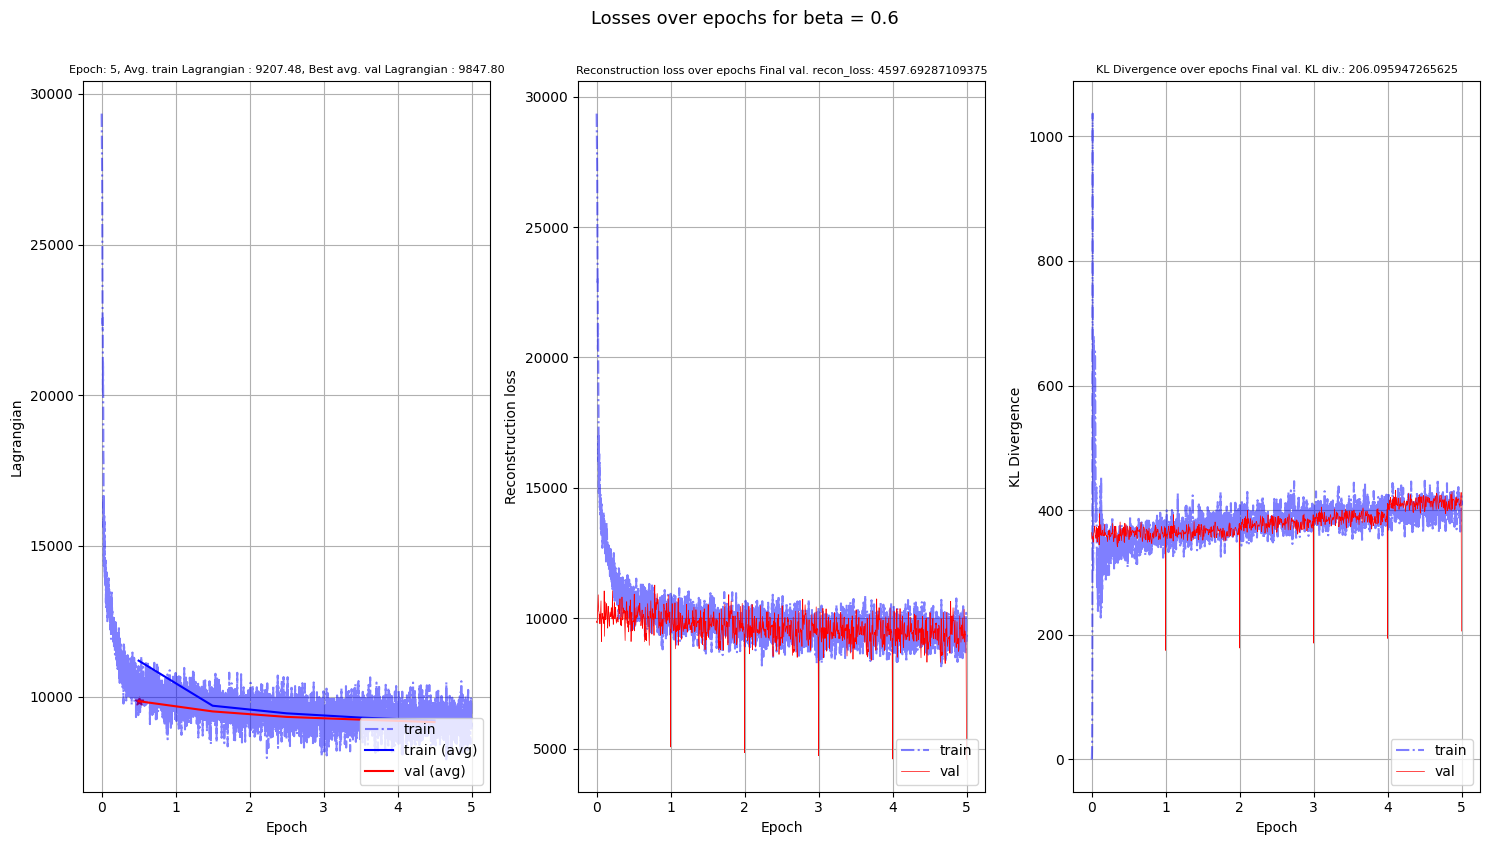

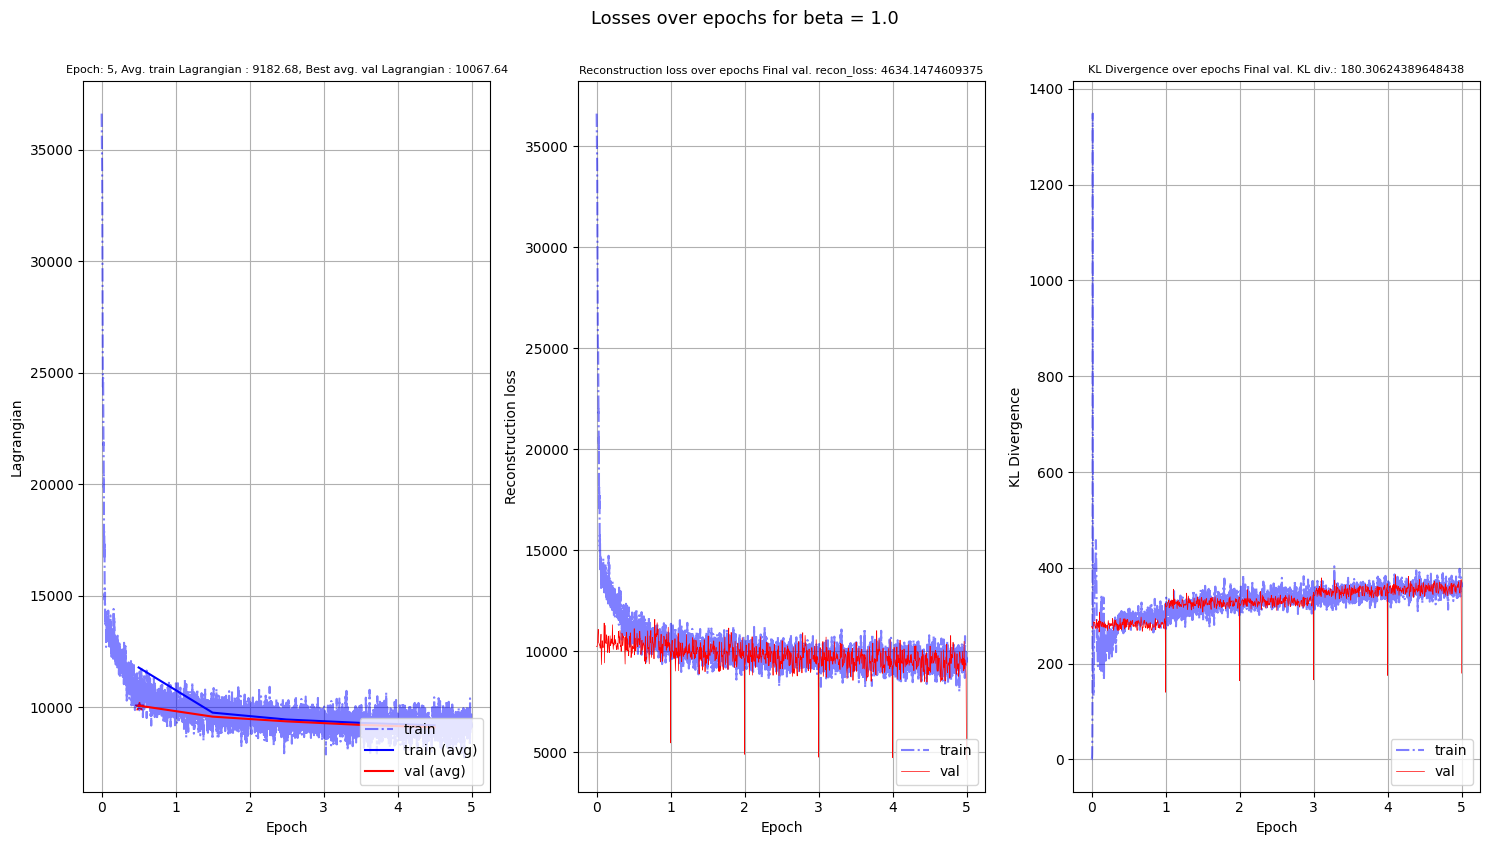

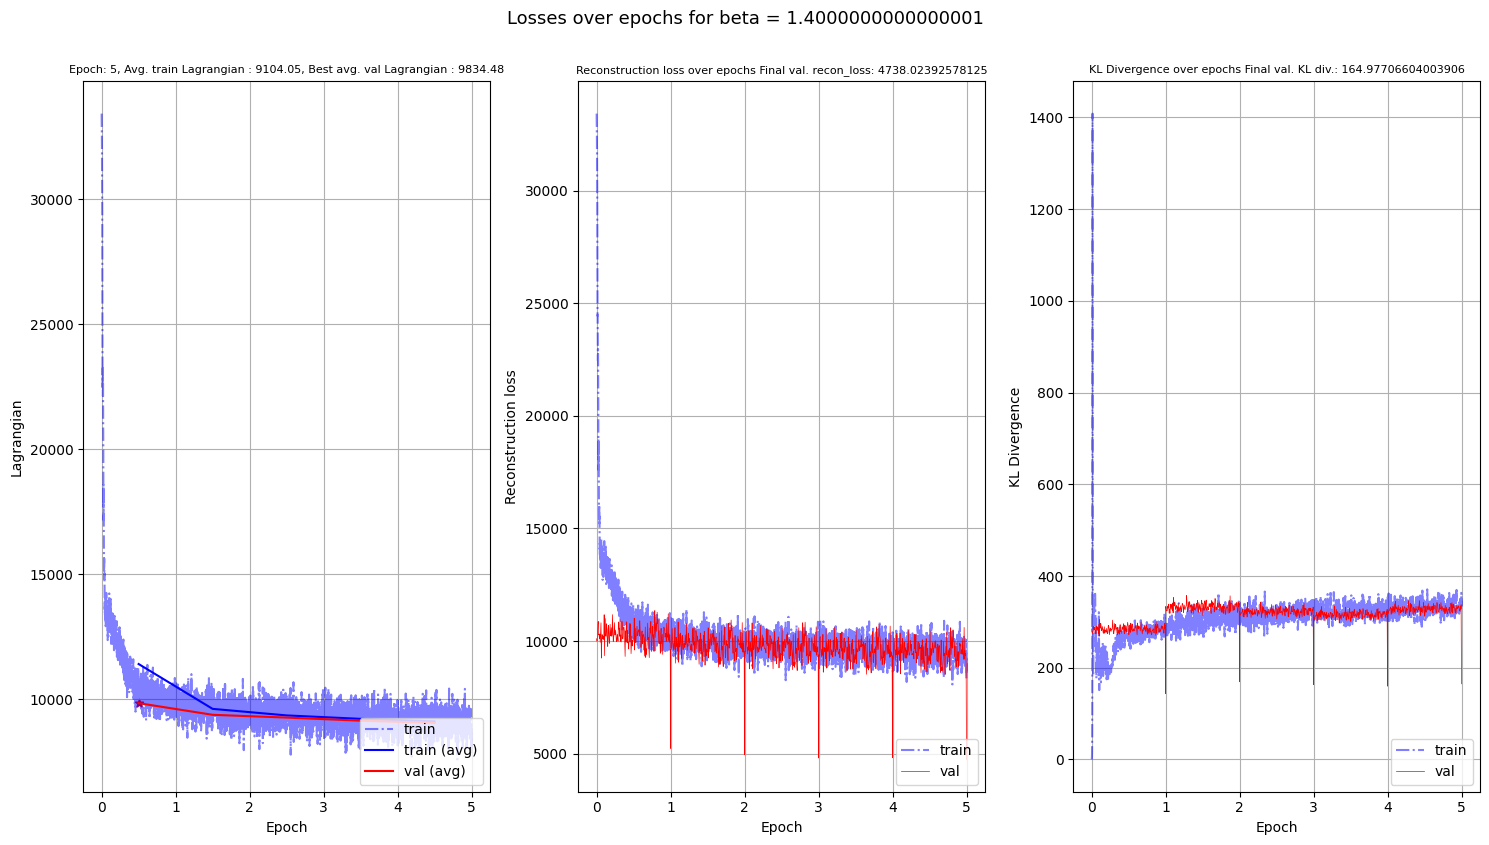

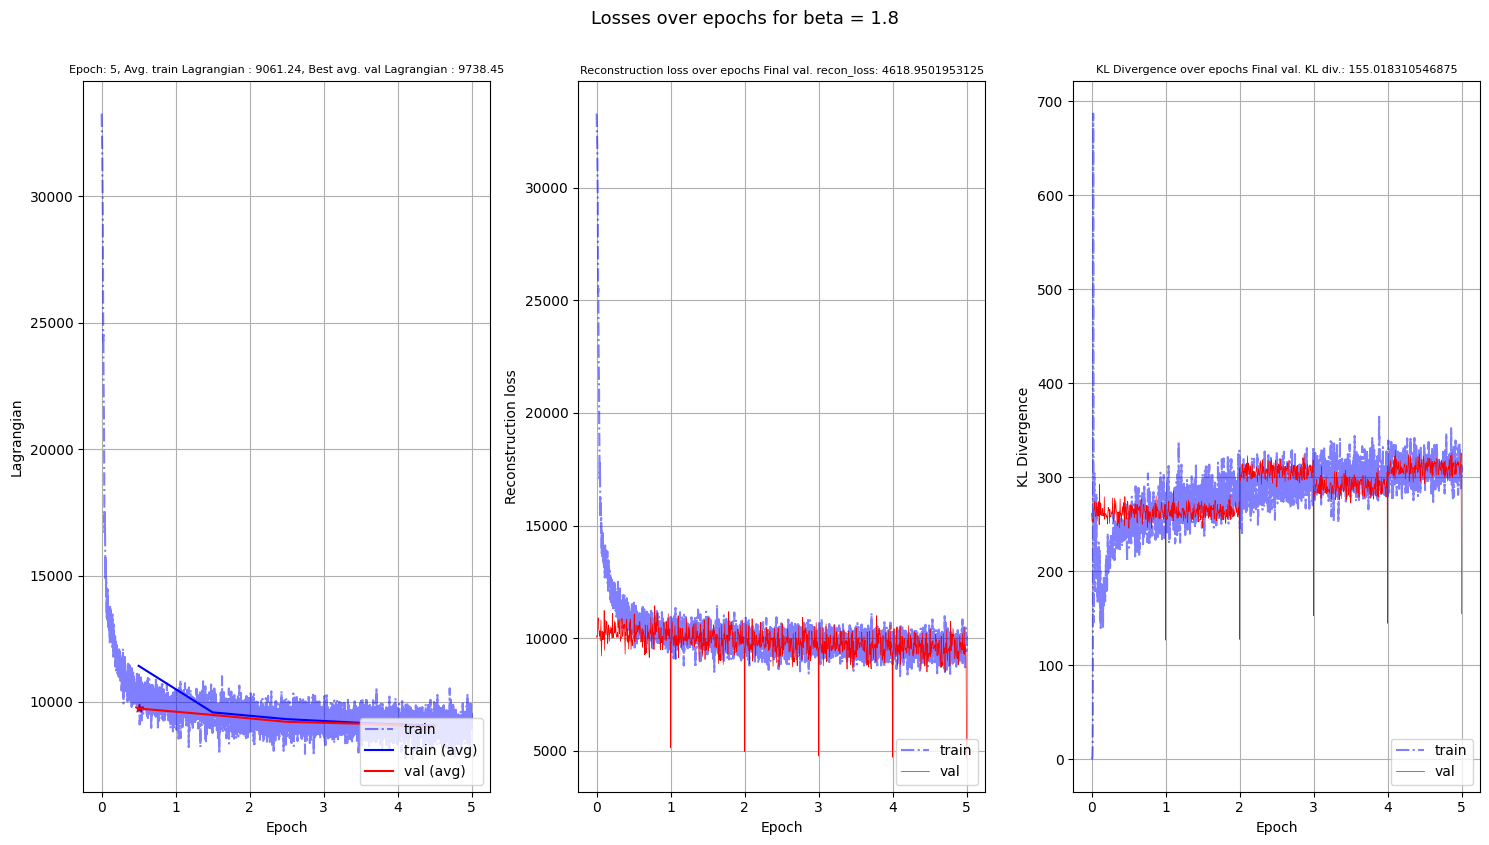

In [34]:
betas = np.linspace(0.6 , 1.8, 4)
# betas = [1]
vae_models = []
vae_outs = []
for beta in betas:
    
    best_vae, _, out, _ = train_vae(beta)
    vae_models.append(best_vae)
    vae_outs.append(out)

In [35]:
# # Plotting code

# #######################################################################
# #                       ** START OF YOUR CODE **
# #######################################################################

### I TRAIN AND PLOT JOINTLY. PLEASE SEE ABOVE FOR THE PLOTS

# #######################################################################
# #                       ** END OF YOUR CODE **
# #######################################################################

## Plot loss (3 points)

Analyze and discuss:

1.   Loss curves (reconstruction and KL divergence)
2.   Explain how different values of $\beta$ affect your training.

<font color='red'>***YOUR ANSWER***</font>

I train the conv. VAE over 5 epochs with fixed learning rate of 0.001 and latent dimension of 2, over 4 values of beta in [0.6, 1, 1.4, 1.8] and notice $\beta=1.8$ to be the best value that balances the trade of reconstruction loss and KL divergence, i.e. it achieves the second-lowest reconstruction loss, lowest KL divergence and overall lowest Lagrangian. The first panel plots 3 curves: the pointwise train Lagrangian, the average train and validation Lagrangian over the training batch. In the second I plot 2 curves, the pointwise training and validation reconstruction losses over epochs and in the third panel I plot the KL divergence. 

1.   For all $\beta$ values, both loss curves (2nd and 3rd panel in each figure corresponding to reconstruction loss and KL divergence, respectively) decrease, indicating the VAE is learning to both reconstruct the MNIST digits, and encouraging disentanglement of latent space. A common pattern is this great leap from a very high loss to a very low value within 1 epoch, albeit afterwards there is a lot of variance during updates. Such variance is partly due to the VAE trying to balance the reconstruction loss and KL divergence, as minimizing one often involves compromising the other, yet they have to be jointly minimized in the Lagrangian term.   
2. $\beta$ controls the trade-off between reconstruction loss and disentanglement of latent space. A large $\beta$ value encourages disentanglement, such as in $\beta=1.8$ achieving a KL divergence of 164, however, this can be at the expense of reconstruction quality and thus slow-down the convergence of the reconstruction loss. Similar reasoning applies for small $\beta$ whereby a model ignores the KL divergence and prioritize reconstruction quality (recon_loss of 4621 for $\beta=0.6$), which hinders interpretability and may lead to memorizing certain digits that are reconstructed very well (i.e. lead to overfitting). A $\beta=1$ leads to the Lagrangian objective function become the ELBO or Evidence of Lower Bound, a lower bound approximation to the log-likelihood of the data $p(x)$.   

There are also some low spikes which are only present in the validation (red) curves at the end of an epoch, which I'm not sure what is the cause. Achieving a low validation loss at the end of the training epoch could be a sign of memorizing the training distribution, though I wouldn't worry too much since the validation curve behaves normally after the epoch starts again. 




## Sample and reconstruction quality (6 points)
Simply run the below cell to show the output

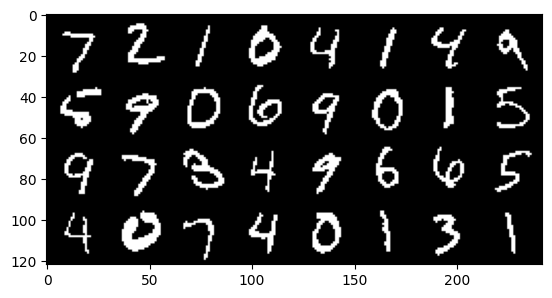

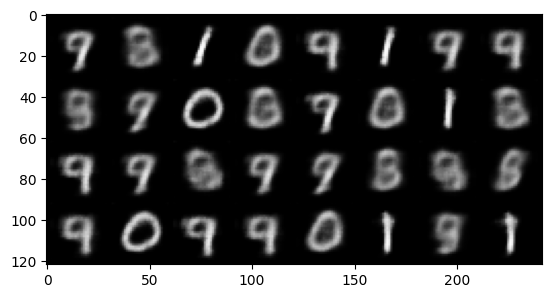

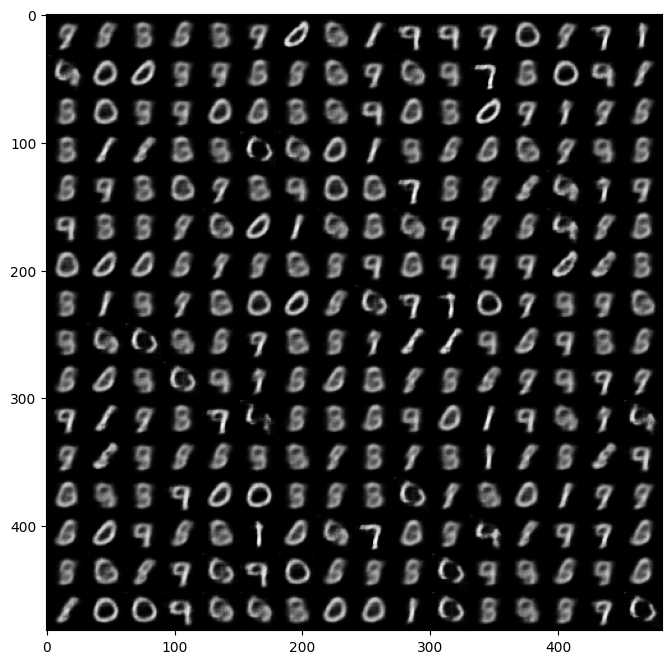

In [43]:
# Input images
model = vae_models[-1] # best model seemed to be that of beta = 1.8, i.e., the last model
model.eval()
sample_inputs, _ = next(iter(test_dataloader))
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denormalize(fixed_input), nrow=8, padding=2, normalize=False,
                scale_each=False, pad_value=0)
plt.figure()
show(img)

# Reconstructed images
with torch.no_grad():

    recon_batch, mu, logvar  = model(sample_inputs.to(device))
    recon_batch = recon_batch.unsqueeze(1).reshape(-1,1,28,28)
    recon_batch = recon_batch[0:32, :, :, :]
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denormalize(recon_batch), nrow=8, padding=2, normalize=False,
                            scale_each=False, pad_value=0)
    # pdb.set_trace()
    plt.figure()
    show(recon_batch)

# Generated Images
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():

    samples = model.decode(z)
    samples = samples.unsqueeze(1).reshape(-1,1,28,28)
    samples = samples.cpu()
    samples = make_grid(denormalize(samples), nrow=16, padding=2, normalize=False,
                            scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)

## Reconstruction and generated samples discussion (5 points)
Analyze and briefly discuss:

1.   Reconstruction quality
2.   Generated samples quality

Explain in your answers how they relate to different values of $\beta$, latent dimension and VAE architecture

<font color='red'>***YOUR ANSWER***</font>

1. The reconstruction quality (second row of images) of $\beta=1.8$ seems a bit blurrier compared to $\beta=0.6$. For this value of $\beta$, the digits are easier to be distinguished between one another, 0 from 1 from 9. This is expected given that larger $\beta$ values prioritize latent disentanglement even if it's at the expense of reconstruction quality.  A larger size of the latent dimension of z can also improve reconstruction quality by allowing more intricate reconstructions. 
2. For $\beta=0.6$, I observe several generated samples are zeros. Each zero is reconstructed with high quality. This shows that by compromising latent disentanglement, the VAE memorized certain digits in order to increase their reconstruction quality, thus lacking diversity in its output. The size of the latent dimension of z can also impact the generated sample quality, as a larger latent space can provide more flexibility in generating diverse samples, albeit it might be slower to train than using a smaller latent dimension. Furthermore, for larger $z$, sampling becomes harder and can not guarantee good coverage in the latent space.

I think for both reconstruction and generated sample quality would see a big improvement if I use a more expressive VAE encoder and decoder, along with a larger latent dimension instead of 2. As it is now, there are only ~50000 parameters in the VAE, which is very low. I could improve by adding more convolutional layers, training for longer epochs, and performing data augmentation techniques on the training data, such as rotation (taking care of 6 and 9), translation, blur, adding noise, among others so that the VAE learns to reconstruct data with greater diversity. Although this comes at the expense of consuming more computational resources, as well as more intricate considerations such as how to prevent overfitting, gradient vanishing, sampling efficiency, etc. 

## T-SNE on Embeddings (5 points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

Run the below cells (no coding required).

Qualitatively assess the learned representations of your model using the T-SNE plots.


In [39]:
alt.data_transformers.disable_max_rows()

def plot_tsne(tsne_xy, dataloader, num_points=1000):

    images, labels = zip(*[(x[0].numpy()[0,:,:,None], x[1]) for x in dataloader.dataset])

    num_points = min(num_points, len(labels))
    data = pd.DataFrame({'x':tsne_xy[:, 0], 'y':tsne_xy[:, 1], 'label':labels,
                        'image': images})
    data = data.sample(n=num_points, replace=False)

    alt.renderers.set_embed_options('light')
    selection = alt.selection_point(on='mouseover', clear='false', nearest=True)
                                    # init={'x':data['x'][data.index[0]], 'y':data['y'][data.index[0]]}) # package errors
    scatter = alt.Chart(data).mark_circle().encode(
        alt.X('x:N',axis=None),
        alt.Y('y:N',axis=None),
        color=alt.condition(selection,
                            alt.value('lightgray'),
                            alt.Color('label:N')),
        size=alt.value(100),
        tooltip='label:N'
    ).add_params(
        selection
    ).properties(
        width=400,
        height=400
    )

    digit  = alt.Chart(data).transform_filter(
        selection
    ).transform_window(
        index='count()'           # number each of the images
    ).transform_flatten(
        ['image']                 # extract rows from each image
    ).transform_window(
        row='count()',            # number the rows...
        groupby=['index']         # ...within each image
    ).transform_flatten(
        ['image']                 # extract the values from each row
    ).transform_window(
        column='count()',         # number the columns...
        groupby=['index', 'row']  # ...within each row & image
    ).mark_rect(stroke='black',strokeWidth=0).encode(
        alt.X('column:O', axis=None),
        alt.Y('row:O', axis=None),
        alt.Color('image:Q',sort='descending',
            scale=alt.Scale(scheme=alt.SchemeParams('lightgreyteal',
                            extent=[1, 0]),

            ),
            legend=None
        ),
    ).properties(
        width=400,
        height=400,
    )

    return scatter | digit

In [40]:
# TSNE
from sklearn.manifold import TSNE

for t, (x, y) in enumerate(test_dataloader):
    if t == 0:
        data = x
        labels = y
    else:
        data = torch.cat((data, x))
        labels = torch.cat((labels, y))

# Then let's apply dimensionality reduction with the trained encoder

with torch.no_grad():
    data = data.to(device)
    mu, logvar = model.encode(data)
    z = (model.reparametrize(mu, logvar)).cpu().detach().numpy()

z_embedded = TSNE(n_components=2).fit_transform(z)

In [41]:
plot_tsne(z_embedded, test_dataloader, num_points=1000)

alt.HConcatChart(...)

### Discussion
Analyze and discuss the visualized T-SNE representations

1. What role do the KL loss term and $\beta$ have?
2. Can you find any outliers?

<font color='red'>***YOUR ANSWER***</font>

1. Because $\beta$ moderates the importance of the KL divergence, and the KL divergence determines the disentanglement of the latent space, both these terms affect whether in regions of dots of certain color, say orange dots, I'm able to find only a particular digit. In my plot, for instance, I mostly find 1 in the orange region in the upper left. As we go closer to the center, we observe disentanglement to be more difficult, as the latent space tend to conflate number 6 with 8 and 3 or 1 with 7, which is understandable given they look alike. A larger beta, coupled with a larger dimension for z in the KL loss term could help disentangle furthermore the points above. 
2. It depends on what you mean by outlier. By only looking at the T-SNE representations, we can define an outlier as a digit which is placed far away from its well-defined cluster, into a region of digits that are clearly different to it. For example, a 1 appearing very far from the orange region would be an outlier. Following this definition, I can identify some orange dots corresponding to 1 in the middle left region that are clearly far away from the main cluster of 1 in the upper left region. These digits 1s are placed close to 9, 4 and 7, probably because image-wise they look alike. However, this definition of outlier is disputable given that conventionally, an outlier could refer to one of the extremely unlikely instances where a digit is mislabeled, such as a digit 1 mislabeled as a 3. However, whether we are able to identify this from the embedding space is disputable since the influence of outliers may have been smoothed given a larger batch of correctly labeled training data.   